# Build stratified dataset (MHS data)

__Objective:__ create a train/test splits from the [Measuring Hate Speech corpus](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech) satisfying the following criteria
- stratification **by class** (class frequencies roughly the same between training and test data),
- stratification **by annotator** (the **same annotators** must appear both in the training and test data - otherwise we have the cold start problem for the annotator-specific models),
- no comment is replicated between training and test data (for different annotators) - otherwise there's clear data leakage,
- each annotator has **at least** some number samples in the training split (an absolute minimum number, to allow for the annotator-specific model to learn).

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append('../../modules/')

from custom_logger import get_logger

logger = get_logger('build_stratified_dataset')

sns.set_theme()

%load_ext autoreload
%autoreload 2

## Load full dataset and extreme annotators data

In [3]:
MHS_DATA_PATH = '../../data/clean/mhs_10_samples_per_annotator.csv'
# MHS_ANNOTATORS_DATA_PATH = '../../data/clean/annotators_data_mhs.csv'  # Original one used for the training.
MHS_ANNOTATORS_DATA_PATH = '../../data/clean/annotators_data_mhs_10_samples_per_annotator.csv'

In [4]:
data_df = pd.read_csv(MHS_DATA_PATH)
annotators_data = pd.read_csv(MHS_ANNOTATORS_DATA_PATH)

data_df = pd.merge(
    left=data_df,
    right=annotators_data[['annotator_id', 'extreme_annotator']],
    how='left',
    on='annotator_id'
)

data_df

,text_id,annotator_id,toxic_score,text,extreme_annotator
0,43625,7365,0,It is about time for all illegals to go back t...,True
1,23643,9750,0,9) uhhhh i like being lgbt a lot. i feel proud...,False
2,20583,7259,0,@terryelaineh1 @UKLabour Why do 3.8 million #5...,False
3,23016,10173,0,Ladies buy a gun learn how to use it effective...,False
4,15758,8749,0,"No, they only do that to black people",False
...,...,...,...,...,...
45028,20064,9905,0,Lailat al Miraj mubarak to all Muslims.. I'm w...,False
45029,20059,1257,0,happy pride month i'm gay URL,False
45030,20060,611,0,I love that you enjoy being trans.,False
45031,20067,7414,0,"Please help support nonbinary pride, add a #Tw...",False


In [5]:
data_df[data_df['annotator_id'].isin((data_df.groupby('annotator_id')['extreme_annotator'].nunique() > 1).index)].sort_values(by='annotator_id')

,text_id,annotator_id,toxic_score,text,extreme_annotator
28840,20034,1,0,gay people should die,False
2213,49792,1,0,I would not know his guest is white or black i...,False
41253,20055,1,0,There is plenty of evidence that women and non...,False
5881,5609,1,1,"Fuck religion, especially Islam, and fuck all ...",False
22316,31029,1,0,"Please dont say ""cosmopolitan"" is anti-Semitic...",False
...,...,...,...,...,...
10258,1138,11142,0,U R the gey?,False
38899,20032,11142,1,shut the fuck up you dumb black bitch,False
21254,23136,11142,0,"To all the non-queer people here, two words to...",False
2412,34749,11142,0,Israelis want peace. They gave up Gaza for pea...,False


In [6]:
data_df[data_df['annotator_id'] == 11127]

,text_id,annotator_id,toxic_score,text,extreme_annotator
9963,27399,11127,0,My love for #shemales shaa... Who else love 'e...,False
11362,11372,11127,0,"Fuck gays and lesbians fuck them, they poison ...",False
14111,44017,11127,0,+Female Russia DIRTY FILTHY DISEASE CARRYING M...,False
16955,30373,11127,0,LESBIANS DONT WANT TO DATE MEN ARE YALL FUCKIN...,False
20993,6971,11127,0,I'm not your dude ya fat slut. Go spew your bu...,False
22253,6572,11127,0,"She killed another human, her own kid and she'...",False
23539,43326,11127,0,Being a zipper head and a faggot must be tryin...,False
24817,45733,11127,0,"+John Omoruan Well, I guess you're wright. It ...",False
28661,20047,11127,0,i hate jews so much i wish the holocaust actua...,False
31868,20013,11127,0,"At 7:19 is why I hate people, women especially...",False


In [7]:
# Fraction of extreme annotators.
annotators_data['extreme_annotator'].mean()

np.float64(0.10041103934233706)

## Analysis

Distribution of number of annotated comments per annotator.

In [8]:
annotations_counts = data_df.groupby('annotator_id')['text_id'].count().reset_index().rename(columns={'text_id': 'n_annotations'})

annotations_counts

,annotator_id,n_annotations
0,1,14
1,4,12
2,9,11
3,12,13
4,14,14
...,...,...
3401,11134,10
3402,11138,11
3403,11139,12
3404,11141,16


Text(0.5, 1.0, 'Distribution of number of annotations per annotator')

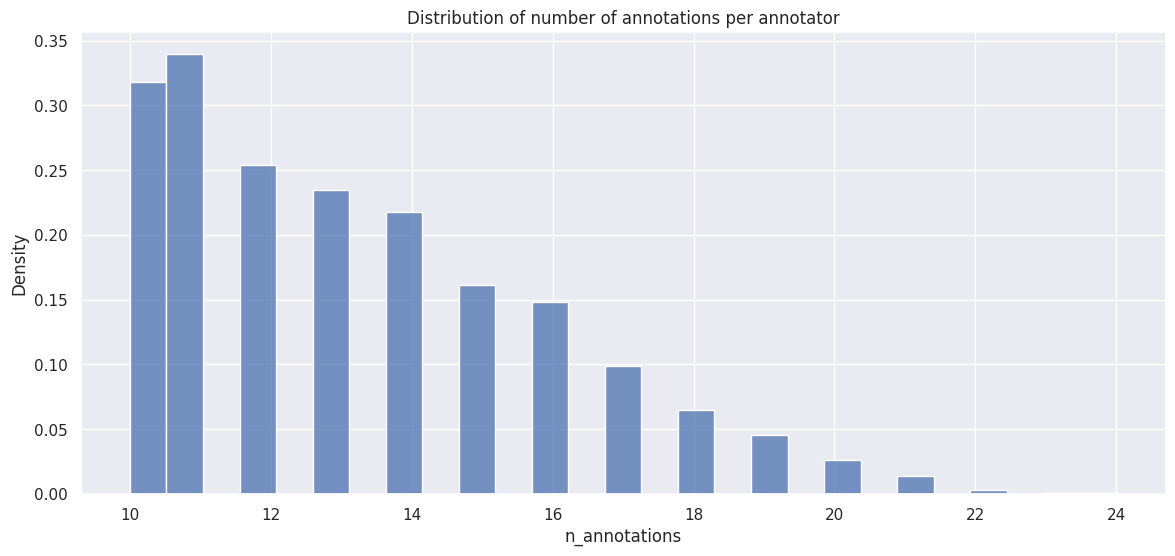

In [9]:
fig = plt.figure(figsize=(14, 6))

sns.histplot(
    x=annotations_counts['n_annotations'],
    stat='density'
)

plt.title('Distribution of number of annotations per annotator')

## Dataset construction

Steps:
1. Set a minimum number of training and test annotations an annotator must have: below these either there aren't enough samples to train an annotator-specific model or there aren't enough samples to evaluate such a model after training.

In [10]:
(annotations_counts.groupby('n_annotations')['annotator_id'].count().sort_index() / len(annotations_counts))

n_annotations
10    0.165003
11    0.176160
12    0.131826
13    0.121844
14    0.113036
15    0.083676
16    0.076923
17    0.051380
18    0.033470
19    0.023488
20    0.013506
21    0.007046
22    0.001762
23    0.000587
24    0.000294
Name: annotator_id, dtype: float64

In [11]:
# Set the minimum number of training and test annotations we want
# for each annotator.
min_n_annotations_training, min_n_annotation_test = (7, 3)  # If they add up to at least 12 we don't discard any annotator. Original values: (8, 4).

logger.info(
    'Filtering for number of annotations'
    f' | Min n annotations training: {min_n_annotations_training}'
    f' | Min n annotations test: {min_n_annotation_test}'
)

# Filter out the annotators who don't have enough annotations.
selected_annotators = annotations_counts[
    annotations_counts['n_annotations'] >= min_n_annotations_training + min_n_annotation_test
]['annotator_id'].tolist()

logger.info(
    f'N annotators (original): {len(annotations_counts)}'
    f' | N annotators (after filtering): {len(selected_annotators)}'
    f' | N dropped annotators: {len(selected_annotators) - len(annotations_counts)}'
)

# Filter the dataset to contain only the selected annotators.
original_dataset_size = len(data_df)

data_df = data_df[data_df['annotator_id'].isin(selected_annotators)].reset_index(drop=True)

logger.info(
    f'Dataset size (original): {original_dataset_size}'
    f' | Dataset size (after annotator filtering): {len(data_df)}'
)

2025-05-12 18:26:07,836 - build_stratified_dataset - INFO - Filtering for number of annotations | Min n annotations training: 7 | Min n annotations test: 3
2025-05-12 18:26:07,837 - build_stratified_dataset - INFO - N annotators (original): 3406 | N annotators (after filtering): 3406 | N dropped annotators: 0
2025-05-12 18:26:07,840 - build_stratified_dataset - INFO - Dataset size (original): 45033 | Dataset size (after annotator filtering): 45033


In [12]:
data_df

,text_id,annotator_id,toxic_score,text,extreme_annotator
0,43625,7365,0,It is about time for all illegals to go back t...,True
1,23643,9750,0,9) uhhhh i like being lgbt a lot. i feel proud...,False
2,20583,7259,0,@terryelaineh1 @UKLabour Why do 3.8 million #5...,False
3,23016,10173,0,Ladies buy a gun learn how to use it effective...,False
4,15758,8749,0,"No, they only do that to black people",False
...,...,...,...,...,...
45028,20064,9905,0,Lailat al Miraj mubarak to all Muslims.. I'm w...,False
45029,20059,1257,0,happy pride month i'm gay URL,False
45030,20060,611,0,I love that you enjoy being trans.,False
45031,20067,7414,0,"Please help support nonbinary pride, add a #Tw...",False


Compute splits and evaluation metric for the obtained splits.

In [13]:
def create_splits_on_text_ids(data_df, train_test_split):
    """
    Splits the train and test splits of the dataset by partitioning
    the text IDs according to the selected fraction and then propagating
    this to the samples themselves.
    """
    # Impose the train-test split on the text IDs.
    text_ids = data_df['text_id'].unique()
    
    text_ids_test = np.random.choice(
        text_ids,
        size=text_ids.shape[0],
        replace=False
    )[:int(train_test_split * text_ids.shape[0])]
    
    text_ids_train = text_ids[~np.isin(text_ids, text_ids_test)]
    
    # Propagate the train-test split on the samples.
    data_df_train = data_df[data_df['text_id'].isin(text_ids_train)].reset_index(drop=True)
    data_df_test = data_df[data_df['text_id'].isin(text_ids_test)].reset_index(drop=True)

    return data_df_train, data_df_test


def evaluate_splits(data_df_train, data_df_test, min_n_annotations_training):
    """
    Computes metrics to evaluate the train-test split of the dataset:
      * `test_frac_text_ids`: fraction of text IDs in the test split over the total (should
                              be very close to the `train_test_split` parameter used to
                              create the splits - by construction).
      * `test_frac_samples`: fraction of samples in the test split over the total (should be
                             as close as possible to `train_test_split` again, but this should
                             be verified a posteriori).
      * `annotators_in_both_splits_frac`: fraction of annotators that appear in both splits (should
                                         be as close as possible to 1.).
      * `class_frequencies_splits`: class frequencies across splits (and difference between splits)
                                    (the difference between splits should be as close as possible to 0
                                    so the same imbalance is replicated across the splits in the same
                                    way).
    """
    # Compute the split fraction on the text IDs.
    test_frac_text_ids = data_df_test['text_id'].shape[0] / (data_df_train['text_id'].shape[0] + data_df_test['text_id'].shape[0])
    
    # Compute the split fraction on the samples.
    # Note: at this point we are sure that no piece of text appears both in the training
    #       and in the test dataset.
    test_frac_samples = len(data_df_test) / (len(data_df_test) + len(data_df_train))
    
    # Compute the fraction of annotators appearing both in the training and test split
    # (objective: 1.).
    annotators_in_both_splits = set(data_df_train['annotator_id'].unique()) & set(data_df_test['annotator_id'].unique())
    annotators_in_both_splits_frac = (
        len(annotators_in_both_splits) /
        len(set(data_df_train['annotator_id'].unique()) | set(data_df_test['annotator_id'].unique()))
    )

    # Compute the fraction of annotators that have fewer than `min_n_annotations_training`
    # annotations in the training split.
    annotators_below_minumum_training_frac = (data_df_train.groupby('annotator_id')['text_id'].count() < min_n_annotations_training).mean()
    
    # Compute the class frequencies in the two splits.
    class_frequences_splits = pd.merge(
        left=(data_df_train['toxic_score'].value_counts() / len(data_df_train)).sort_index().reset_index().rename(columns={'count': 'frac_train'}),
        right=(data_df_test['toxic_score'].value_counts() / len(data_df_test)).sort_index().reset_index().rename(columns={'count': 'frac_test'}),
        on='toxic_score',
        how='left'
    )
    
    class_frequences_splits['abs_frac_diff'] = np.abs(class_frequences_splits['frac_train'] - class_frequences_splits['frac_test'])
    
    return (
        test_frac_text_ids,
        test_frac_samples,
        annotators_in_both_splits_frac,
        annotators_below_minumum_training_frac,
        class_frequences_splits
    )

In [19]:
train_test_split = 0.2

data_df_train, data_df_test = create_splits_on_text_ids(data_df, train_test_split)

(
    test_frac_text_ids,
    test_frac_samples,
    annotators_in_both_splits_frac,
    annotators_below_minumum_training_frac,
    class_frequences_splits
) = evaluate_splits(data_df_train, data_df_test, min_n_annotations_training)

print(
    'Test fraction on text IDs:',
    test_frac_text_ids
)
print(
    'Test fraction split on samples:',
    test_frac_samples
)
print(
    'Fraction of annotators appearing in both splits:',
    annotators_in_both_splits_frac
)
print(
    'Fraction of annotators with fewer than the minumum number of required annotations in the training split:',
    annotators_below_minumum_training_frac
)
print('Class frequencies across splits:')
display(class_frequences_splits)

Test fraction on text IDs: 0.19920946861190683
Test fraction split on samples: 0.19920946861190683
Fraction of annotators appearing in both splits: 0.9351145038167938
Fraction of annotators with fewer than the minumum number of required annotations in the training split: 0.03464474456840869
Class frequencies across splits:


,toxic_score,frac_train,frac_test,abs_frac_diff
0,0,0.604265,0.69524,0.090975
1,1,0.395735,0.30476,0.090975


Refine the splits (i.e. drop samples) to satisfy the hard constraints (not all of them can be satisfied at once by dropping samples though!).

Hard constraints:
- No text appears both in the training and test split --> True for sure by construction, no action needed.
- All annotators appear both in the training and test split --> Drop the samples corresponding to annotators that only appear in one split.
- No annotator is there fewer than the minimum number of annotations required in the training split. --> Drop the samples corresponding to such annotators.

Soft constraints:
- Stratified class frequencies --> Just verify that they are not too off between training and test data after refining the splits.

In [20]:
def refine_splits(data_df_train_original, data_df_test_original, min_n_annotations_training, min_n_annotations_test=None):
    """
    Refines the given training and test splits by dropping all samples (from both sets)
    corresponding to annotators that
      * only appear in one split
    OR
      * have a number of annotations in the training set below the specified minimum.

    If `min_n_annotations_test` is not `None`, then samples corresponding to annotators
    with fewer than `min_n_annotations_test` annotations in the test set are dropped as
    well.
    """
    data_df_train = data_df_train_original.copy()
    data_df_test = data_df_test_original.copy()
    
    # Drop annotators that only appear in one split.
    annotators_in_training_data_only = set(data_df_train['annotator_id']) - set(data_df_test['annotator_id'])
    annotators_in_test_data_only = set(data_df_test['annotator_id']) - set(data_df_train['annotator_id'])
    
    # logger.info(
    #     f'Dropping {len(annotators_in_training_data_only) + len(annotators_in_test_data_only)} annotators appearing only in one split'
    # )
    
    # Drop annotators with fewer than the required annotations in the training set.
    annotators_below_min_training = set(
        data_df_train
        .groupby('annotator_id')['text_id']
        .count()
        .reset_index()
        .rename(columns={'text_id': 'n_annotations'})
        .query(f'n_annotations < {min_n_annotations_training}')['annotator_id']
    )

    # logger.info(
    #     f'Dropping {len(annotators_below_min_training)} annotators with n training annotations below the required minimum'
    # )

    if min_n_annotations_test is not None:
        annotators_below_min_test = set(
            data_df_test
            .groupby('annotator_id')['text_id']
            .count()
            .reset_index()
            .rename(columns={'text_id': 'n_annotations'})
            .query(f'n_annotations < {min_n_annotations_test}')['annotator_id']
        )

        # logger.info(
        #     f'Dropping {len(annotators_below_min_test)} annotators with n test annotations below the required minimum'
        # )
    
    # Drop all samples corresponding to the filtered out annotators.
    if min_n_annotations_test is not None:
        annotators_to_drop = list(
            annotators_in_training_data_only
            | annotators_in_test_data_only
            | annotators_below_min_training
            | annotators_below_min_test
        )
    else:
        annotators_to_drop = list(
            annotators_in_training_data_only
            | annotators_in_test_data_only
            | annotators_below_min_training
        )
    
    n_training_samples_original = data_df_train.shape[0]
    n_test_samples_original = data_df_test.shape[0]
    
    data_df_train = data_df_train[~data_df_train['annotator_id'].isin(annotators_to_drop)].reset_index(drop=True)
    data_df_test = data_df_test[~data_df_test['annotator_id'].isin(annotators_to_drop)].reset_index(drop=True)
    
    n_dropped_samples_train = n_training_samples_original - data_df_train.shape[0]
    n_dropped_samples_test = n_test_samples_original - data_df_test.shape[0]
    
    # logger.info(
    #     f'{n_dropped_samples_train} samples dropped from training data ({round(100.* n_dropped_samples_train / n_training_samples_original, 1)}%)'
    #     f' | {n_dropped_samples_test} samples dropped from training data ({round(100.* n_dropped_samples_test / n_test_samples_original, 1)}%)'
    # )
    # logger.info(
    #     f'N training samples: {len(data_df_train)} | N test samples: {len(data_df_test)}'
    # )

    return data_df_train, data_df_test

In [57]:
# Impose the train-test split on the text IDs.
text_ids = data_df['text_id'].unique()

text_ids_test = np.random.choice(
    text_ids,
    size=text_ids.shape[0],
    replace=False
)[:int(0.2 * text_ids.shape[0])]

text_ids_train = text_ids[~np.isin(text_ids, text_ids_test)]

# Propagate the train-test split on the samples.
data_df_train = data_df[data_df['text_id'].isin(text_ids_train)].reset_index(drop=True)
data_df_test = data_df[data_df['text_id'].isin(text_ids_test)].reset_index(drop=True)

# Refine splits.
data_df_train, data_df_test = refine_splits(
    data_df_train,
    data_df_test,
    min_n_annotations_training,
    min_n_annotations_test=4
)

# Evaluate the refined splits.
(
    test_frac_text_ids,
    test_frac_samples,
    annotators_in_both_splits_frac,
    annotators_below_minumum_training_frac,
    class_frequences_splits
) = evaluate_splits(data_df_train, data_df_test, min_n_annotations_training)

print(
    'Total N samples:',
    len(data_df_train) + len(data_df_test)
)

print(
    'Test fraction on text IDs:',
    test_frac_text_ids
)
print(
    'Test fraction split on samples:',
    test_frac_samples
)
print(
    'Fraction of annotators appearing in both splits:',
    annotators_in_both_splits_frac
)
print(
    'Fraction of annotators with fewer than the minumum number of required annotations in the training split:',
    annotators_below_minumum_training_frac
)
print('\nClass frequencies across splits:')
display(class_frequences_splits)

Total N samples: 2204
Test fraction on text IDs: 0.2881125226860254
Test fraction split on samples: 0.2881125226860254
Fraction of annotators appearing in both splits: 1.0
Fraction of annotators with fewer than the minumum number of required annotations in the training split: 0.0

Class frequencies across splits:


,toxic_score,frac_train,frac_test,abs_frac_diff
0,0,0.644997,0.606299,0.038698
1,1,0.355003,0.393701,0.038698


Randomly create splits and keep the one with the most total samples.

In [21]:
n_trials = 10000

previous_total_n_samples = None

min_n_annotations_test = 3

for _ in tqdm(range(n_trials)):
    data_df_train, data_df_test = create_splits_on_text_ids(data_df, train_test_split)

    data_df_train, data_df_test = refine_splits(
        data_df_train,
        data_df_test,
        min_n_annotations_training,
        min_n_annotations_test=min_n_annotations_test
    )

    total_n_samples = len(data_df_train) + len(data_df_test)

    if (previous_total_n_samples is None) or (total_n_samples > previous_total_n_samples):
        previous_total_n_samples = total_n_samples

        logger.info(f'Saving data. Total n samples: {total_n_samples}')

        # Save data.
        data_df_train.to_csv('/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_train_10_samples_per_annotator.csv', index=None)
        data_df_test.to_csv('/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_test_10_samples_per_annotator.csv', index=None)

  0%|          | 0/10000 [00:00<?, ?it/s]

2025-05-12 18:28:21,565 - build_stratified_dataset - INFO - Saving data. Total n samples: 23825
2025-05-12 18:28:21,680 - build_stratified_dataset - INFO - Saving data. Total n samples: 25228
2025-05-12 18:28:21,994 - build_stratified_dataset - INFO - Saving data. Total n samples: 28252
2025-05-12 18:28:23,733 - build_stratified_dataset - INFO - Saving data. Total n samples: 28321
2025-05-12 18:28:26,710 - build_stratified_dataset - INFO - Saving data. Total n samples: 29009
2025-05-12 18:28:27,030 - build_stratified_dataset - INFO - Saving data. Total n samples: 29703
2025-05-12 18:28:28,588 - build_stratified_dataset - INFO - Saving data. Total n samples: 29722
2025-05-12 18:28:32,430 - build_stratified_dataset - INFO - Saving data. Total n samples: 29873
2025-05-12 18:28:37,818 - build_stratified_dataset - INFO - Saving data. Total n samples: 30062
2025-05-12 18:29:05,944 - build_stratified_dataset - INFO - Saving data. Total n samples: 30096
2025-05-12 18:29:26,899 - build_stratifi

## Checks

In [22]:
data_df_train_loaded = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_train_10_samples_per_annotator.csv')
data_df_test_loaded = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_test_10_samples_per_annotator.csv')
# Original data used for training.
# data_df_train_loaded = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_train.csv')
# data_df_test_loaded = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_test.csv')

# data_df_train_loaded = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_train_unconstrained.csv')
# data_df_test_loaded = pd.read_csv('/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_test_unconstrained.csv')

In [23]:
data_df_train_loaded.shape, data_df_test_loaded.shape

((21742, 5), (9379, 5))

In [24]:
min_n_annotations_training, min_n_annotation_test = (7, 3)  # Original values: (8, 4).

evaluate_splits(data_df_train_loaded, data_df_test_loaded, min_n_annotations_training)

(0.3013720638796954,
 0.3013720638796954,
 1.0,
 np.float64(0.0),
    toxic_score  frac_train  frac_test  abs_frac_diff
 0            0    0.644743   0.585457       0.059286
 1            1    0.355257   0.414543       0.059286)

In [25]:
print(
    'N annotators (train):'
    f" {data_df_train_loaded['annotator_id'].unique().shape[0]}"
    ' | N annotators (test):'
    f" {data_df_test_loaded['annotator_id'].unique().shape[0]}"
)

print(
    'Same annotators in training and test data:',
    set(data_df_train_loaded['annotator_id']) == set(data_df_test_loaded['annotator_id'])
)

N annotators (train): 2219 | N annotators (test): 2219
Same annotators in training and test data: True


In [26]:
(
    data_df_train_loaded.groupby('annotator_id')['text_id'].count().median(),
    data_df_test_loaded.groupby('annotator_id')['text_id'].count().median()
)

(np.float64(9.0), np.float64(4.0))

In [27]:
# Fraction of extreme annotators in the final splits.
(
    data_df_train_loaded.groupby('annotator_id')['extreme_annotator'].first().mean(),
    data_df_test_loaded.groupby('annotator_id')['extreme_annotator'].first().mean()
)

(np.float64(0.09418657052726453), np.float64(0.09418657052726453))

In [28]:
(
    data_df_train_loaded[['annotator_id', 'extreme_annotator']].drop_duplicates()['extreme_annotator'].sum(),
    data_df_test_loaded[['annotator_id', 'extreme_annotator']].drop_duplicates()['extreme_annotator'].sum(),
    annotators_data['extreme_annotator'].sum()
)

(np.int64(209), np.int64(209), np.int64(342))

Text(0.5, 0, 'N annotations')

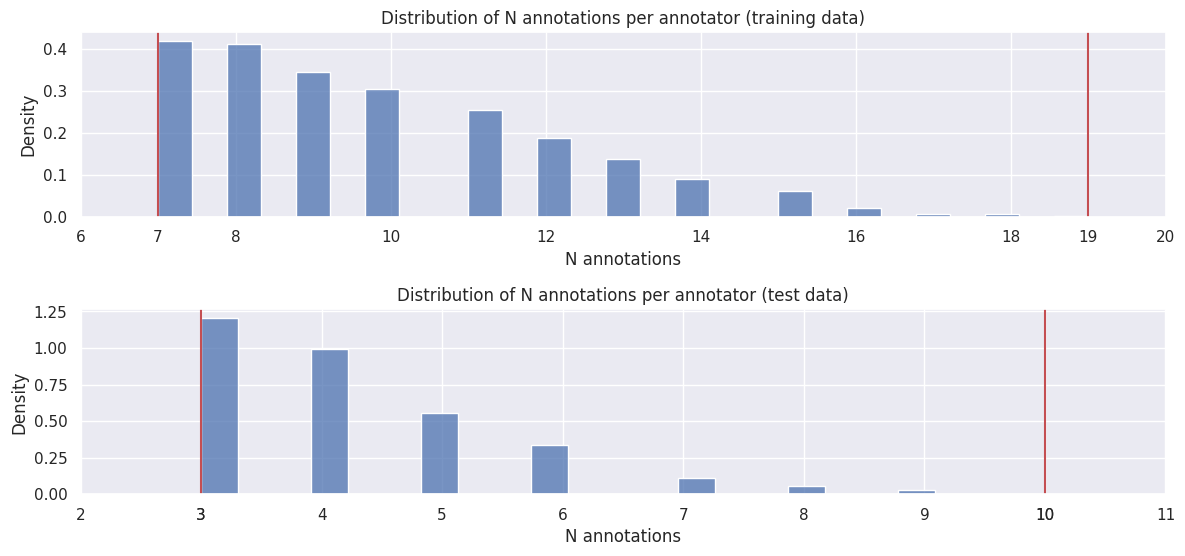

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))

plt.subplots_adjust(hspace=0.5)

# Training data.
sns.histplot(
    x=data_df_train_loaded.groupby('annotator_id')['text_id'].count(),
    stat='density',
    ax=axs[0]
)

plt.sca(axs[0])

plt.axvline(
    x=data_df_train_loaded.groupby('annotator_id')['text_id'].count().min(),
    color='r'
)

plt.axvline(
    x=data_df_train_loaded.groupby('annotator_id')['text_id'].count().max(),
    color='r',
)

plt.xticks(
    list(plt.xticks()[0])
    + [data_df_train_loaded.groupby('annotator_id')['text_id'].count().min()]
    + [data_df_train_loaded.groupby('annotator_id')['text_id'].count().max()],
)
plt.title('Distribution of N annotations per annotator (training data)')
plt.xlabel('N annotations')

# Test data.
sns.histplot(
    x=data_df_test_loaded.groupby('annotator_id')['text_id'].count(),
    stat='density',
    ax=axs[1]
)

plt.sca(axs[1])

plt.axvline(
    x=data_df_test_loaded.groupby('annotator_id')['text_id'].count().min(),
    color='r'
)

plt.axvline(
    x=data_df_test_loaded.groupby('annotator_id')['text_id'].count().max(),
    color='r',
)

plt.xticks(
    list(plt.xticks()[0])
    + [data_df_test_loaded.groupby('annotator_id')['text_id'].count().min()]
    + [data_df_test_loaded.groupby('annotator_id')['text_id'].count().max()],
)
plt.title('Distribution of N annotations per annotator (test data)')
plt.xlabel('N annotations')

In [30]:
data_df_train_loaded.groupby('text_id')['annotator_id'].count().describe()

count    6173.000000
mean        3.522112
std        13.805133
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max       221.000000
Name: annotator_id, dtype: float64

## Annotators subsampling

**WARNING:** this is probably not possible/needed with the MHS dataset.

**Idea:** rank the annotators by number of training (or training+test?) annotations and consider the first N in descending order. Compute the number of samples for different values of N to see the dataset size as a function of the number of annotators considered (starting from ones with the most annotations).

In [ ]:
from data_utils import subsample_dataset

In [ ]:
data_df_train_loaded = pd.read_csv(
    '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean_train.csv'
).drop(columns=['extreme_annotator'])
data_df_test_loaded = pd.read_csv(
    '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean_test.csv'
).drop(columns=['extreme_annotator'])

ANNOTATORS_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/annotators_data.csv'

annotators_data = pd.read_csv(ANNOTATORS_DATA_PATH)

In [ ]:
annotations_per_annotator = (
    data_df_train_loaded
    .groupby('annotator_id')['text_id']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'text_id': 'n_annotations'})
)

annotations_per_annotator['n_annotators_cumulative_sum'] = range(1, len(annotations_per_annotator) + 1)
annotations_per_annotator['n_annotations_cumulative_sum'] = annotations_per_annotator['n_annotations'].cumsum()

# Add annotators data.
annotations_per_annotator = pd.merge(
    left=annotations_per_annotator,
    right=annotators_data[['annotator_id', 'extreme_annotator']],
    on='annotator_id',
    how='left'
)

annotations_per_annotator

In [ ]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=annotations_per_annotator['n_annotators_cumulative_sum'],
    y=annotations_per_annotator['n_annotations_cumulative_sum']
)

Fix the optimal number of training datapoints and get the number of annotators that must be considered.

In [ ]:
optimal_n_datapoints = 150000

data_df_train_subsampled, data_df_test_subsampled = subsample_dataset(
    data_df_train_loaded,
    data_df_test_loaded,
    optimal_n_datapoints,
    ANNOTATORS_DATA_PATH
)

In [ ]:
display(data_df_train_subsampled.groupby('annotator_id')['text_id'].count().describe())
display(data_df_test_subsampled.groupby('annotator_id')['text_id'].count().describe())

# Distribution of N annotations per annotator in the subsampled data.
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))

plt.subplots_adjust(hspace=0.5)

# Training data.
sns.histplot(
    x=data_df_train_subsampled.groupby('annotator_id')['text_id'].count(),
    stat='density',
    ax=axs[0]
)

plt.sca(axs[0])
plt.title('Distribution of number of annotations (training data)')
plt.xlabel('N annotations')

# Test data.
sns.histplot(
    x=data_df_test_subsampled.groupby('annotator_id')['text_id'].count(),
    stat='density',
    ax=axs[1]
)

plt.sca(axs[1])
plt.title('Distribution of number of annotations (test data)')
plt.xlabel('N annotations')